# Prueba de selección para cargo de Ingeniero Data Scientist

## Definición de librerías a usar

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from nsp_prediction.settings import (
    NSP_DATA_URL, TEST_SIZE, SVM_SVC_SPACE, LOG_REG_SPACE
)
from nsp_prediction.utils import (
    preprocess_features,
    BaseClassificationModel,
    select_best_model
)

from covid_cases_prediction.settings import (
    NATIONAL_TOTALS_T_URL, PROPHET_PARAMS_GRID
)
from covid_cases_prediction.utils import train_and_adjust_prophet_model

## 1. Predicción de ausentismo

In [4]:
#se importa la data a usar
nsp_df = pd.read_excel(NSP_DATA_URL)

In [ ]:
nsp_df

,id,fechanacimiento,sexo,prevision,especialidad,tipoatencion,fechareserva,fechahoracita,nsp
0,e1f568d43f199d828c9462e05c784c16,1965-05-18,f,FONASA C,GINECOLOGIA - AGENDA MEDICA,NUEVO,2018-11-12,2018-11-27 11:00:00,0
1,600048a30420b4e18c0385a5ca185be5,1960-04-10,f,FONASA B,GINECOLOGIA - AGENDA MEDICA,NUEVO,2018-11-07,2018-11-16 11:00:00,0
2,dbe9285fa3633f6baea7e382e3f120d0,1992-02-02,f,FONASA B,OBSTETRICIA - AGENDA MEDICA,CONTROL,2018-10-30,2018-11-13 10:30:00,1
3,2c2e153aa1532e16a43807996fd4f348,1986-11-28,f,FONASA D,OBSTETRICIA - AGENDA MEDICA,CONTROL,2018-10-31,2018-11-05 11:00:00,0
4,27b54f22d85a9ffd835c31bdd8277548,1996-07-20,f,FONASA A,OBSTETRICIA - AGENDA MEDICA,CONTROL,2018-10-24,2018-11-06 10:15:00,0
...,...,...,...,...,...,...,...,...,...
1048570,0c71c1fd0dd7ddb1d9cc1dea3b7e1f20,2017-12-31,f,FONASA A,NEONATOLOGIA - AGENDA MEDICA,NUEVO,2018-01-08,2018-01-30 12:00:00,0
1048571,619126c4ee07561901e371ec0f111022,2017-12-18,m,FONASA A,NEONATOLOGIA - AGENDA MEDICA,NUEVO,2017-12-27,2018-01-16 08:00:00,0
1048572,f191accdfcb45396624545e496cf4a04,2017-12-29,m,FONASA B,NEONATOLOGIA - AGENDA MEDICA,NUEVO,2018-01-04,2018-01-23 12:00:00,0
1048573,58eeca448af888be5ea22e65eead8b57,2017-12-16,f,FONASA C,NEONATOLOGIA - AGENDA MEDICA,CONTROL,2017-12-27,2018-01-16 12:00:00,0


**Análisis exploratorio inicial de datos**

In [ ]:
nsp_df.astype('object').describe()

,id,fechanacimiento,sexo,prevision,especialidad,tipoatencion,fechareserva,fechahoracita,nsp
count,1048575,1048575,1048575,1048575,1048575,1048575,1048575,1048575,1048575
unique,152785,32937,2,23,97,51,778,49919,2
top,90da76eda734b4149001b0a13191a97d,1947-12-04 00:00:00,f,FONASA B,MEDICINA GENERAL - AGENDA MEDICA,CONTROL,2018-04-23 00:00:00,2019-08-27 08:00:00,0
freq,200,330,627328,576675,209658,525996,3664,544,863367


Observando los valores obtenidos al describir de forma inicial el dataframe, se puede señalar lo siguiente:

- Existen pacientes que han reservado horas más de una vez. El o la paciente ocn un mayor historial de reservas, ha hecho 200 reservas de horas
- Han sido reservadas más atenciones médicas por mujeres que por hombres. Entendiendo la naturaleza de lo solicitado, esta es una variable que posiblemente no tenga mayor impacto a la hora de predecir si una persona asistirá o no a su hora médica
- Fonasa B es el tipo de previsión más popular, la cual por si sola acapara más de la mitad de las reservas de horas médicas, por sobre otros 22 tipos de previsiones
- Existen 97 tipos de especialidades solicitadas, siendo la más popular medicina general
- Existen 50 tipos de primera o única consulta diferentes. Más de la mitad de las reservas corresponden a control, por lo tanto, más de la mitad de las reservas de horas, corresponden a una segunda o posterior consulta
- En más del 80% de las reservas de horas, el paciente asistió a la consulta, por lo tanto, la clase a predecir está **desbalanceada**, lo que será relevante al momento de definir los modelos a utilizar

En base a estos datos, se muestran los siguientes gráficos, considerando algunas columnas en específico:

<Axes: >

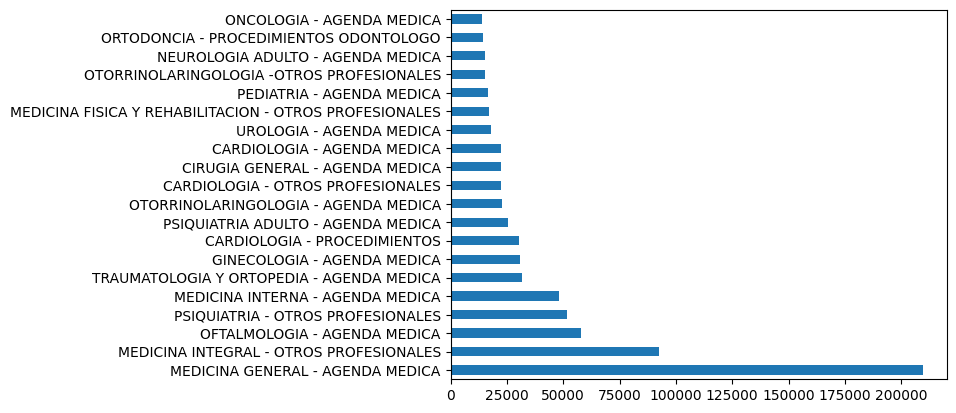

In [ ]:
#gráfico de 20 especialidades más solicitadas
nsp_df['especialidad'].value_counts()[:20].plot(kind='barh')

De acuerdo a lo que se puede observar en el gráfico, sólo para la categoría de medicina general - agenda médica se han solcitado más de 100.000 reservas, lo que representa alrededor del 10% del total de reservas. Luego, sólo 5 categorías superan o se acercan a las 50.000 reservas, lo que representa un valor cercano al 5% del total de reservas

<Axes: >

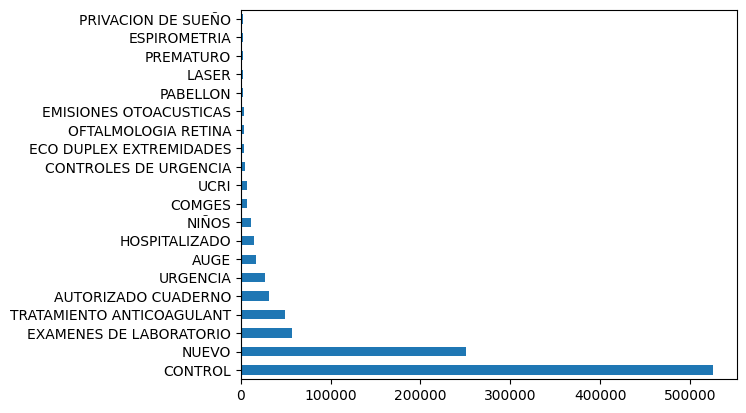

In [ ]:
#gráfico de 20 tipos de atenciones más solicitadas
nsp_df['tipoatencion'].value_counts()[:20].plot(kind='barh')

Revisando la distribución de los tipos de atención, se nota como dos categorías (control y nuevo) son reservadas en más del 70% del total de las reservas, estando el porcentaje restante dividido en 49 categorías diferentes

<Axes: xlabel='fechahoracita'>

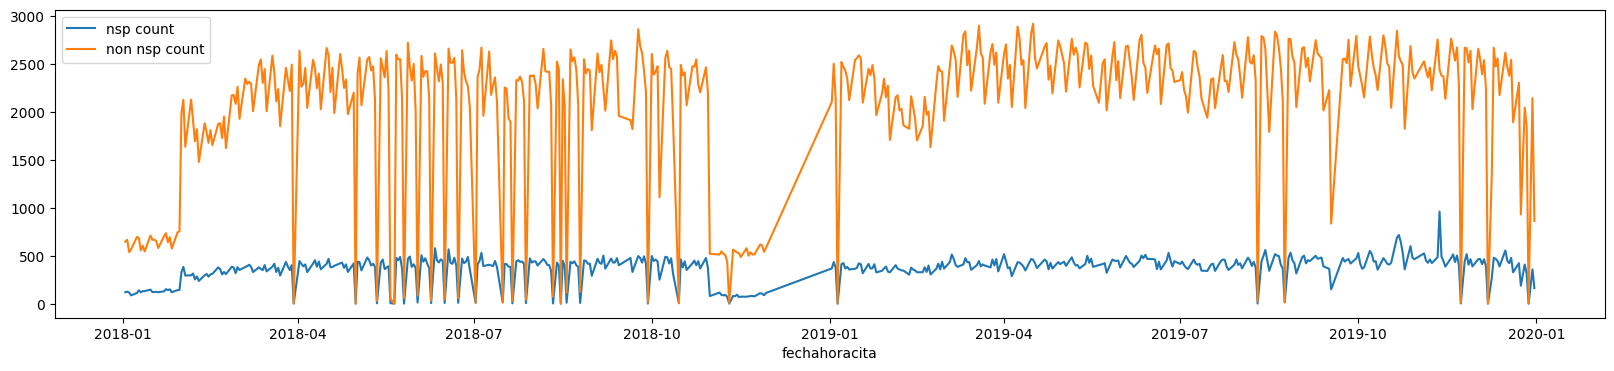

In [ ]:
#cantidad de ausentismo y asistencia a cita médica según fecha de hora
nsp_count_per_date = nsp_df.groupby(nsp_df['fechahoracita'].dt.date)['nsp'].sum()
nsp_count_per_date.name = 'nsp count'
non_nsp_count_per_date = nsp_df.groupby(nsp_df['fechahoracita'].dt.date)['nsp'].apply(lambda x: (x == 0).count())
non_nsp_count_per_date.name = 'non nsp count'

nsp_df_count_per_date = pd.concat([
    nsp_count_per_date,
    non_nsp_count_per_date
], axis=1).reset_index()
nsp_df_count_per_date.plot('fechahoracita', ['nsp count', 'non nsp count'], figsize=(20, 4,))

Viendo el gráfico de total de ausentismo y asistencia a citas médicas a través del tiempo, según los datos entregados, se puede notar cómo la no asistencia a una cita médica se mantiene constante en relación a las asistencias a travéz del tiempo, teniendo peaks y bajas que coinciden entre si, los cuáles pueden atribuirse a diferentes factores, como por ejemplo la celebración de alguna festividad (navidad, año nuevo, entre otras). Llama la atención inicialmente el periodo de fin de año de 2018, cuya tendencia no se repite en el fin de año de 2019, así como también el periodo entre fines de otoño y fin del invierno de 2018, teniendo este último cambios notorios en el total de solicitudes realizadas en periodos cortos de tiempo (días)

**Definición de nuevas variables**

In [5]:
today = datetime.now()

nsp_df['diasespera'] = (nsp_df['fechahoracita'] - nsp_df['fechareserva']).dt.days
nsp_df['edad'] = (today - nsp_df['fechanacimiento']).astype('<m8[Y]')
nsp_df['primeravisita'] = (nsp_df['tipoatencion'] == 'NUEVA').astype('int')
nsp_df['categoriaespecialidad'] = nsp_df['especialidad'].str.split(' - ').str[0]

Luego de la exploración inicial de datos, se decide obtener las siguientes variables:

- **diasespera**: Total de días transcurridos desde que una persona reserva una hora hasta la fecha en la que tiene la cita
- **edad**: Edad en años de la persona que reservó la hora
- **primeravisita**: Variable que indica si la consulta reservada corresponde a una consulta inicial o a un control posterior
- **categoriaespecialidad**: Categoría mayor de la especialidad indicada en la reserva de hora

**Pre-procesamiento para entrenamiento**

In [6]:
# Definición de columnas a usar en entrenamiento y columna a predecir
X = nsp_df[[
    'diasespera',
    'edad',
    'primeravisita',
    'prevision',
    'sexo',
    'categoriaespecialidad',
]]
Y = nsp_df['nsp']

#preprocesamiento de features para entrenamiento
X = preprocess_features(X)

# Divide dataset en conjuntos de entrenamiento(80%) y testing(20%)
# realizando shuffling con el mismo seed en cada ejecución del código
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=TEST_SIZE, stratify=Y, random_state=46
)

**Entrenamiento y ajuste de modelos a usar**

Para el entrenamiento y ajuste de diferentes modelos, se crea en primer lugar la clase BaseClassificationModel, en la cual se definen las funciones a utilizar para entrenar y obtener predicciones en cada modelo a entrenar. Dentro de esta clase, se define la función train_adjust, en la cual se utiliza el módulo GridSearchCV de scikit-learn para ajustar de forma válida cada uno de los modelos considerados, según el diccionario de posibles parámetros entregados en grid_params

Teniendo en cuenta que, según la exploración de datos presentada anteriormente, la columna a predecir no está balanceada, al momento de ajustar los modelos en su entrenamiento, se decide utilizar f-beta score sobre el valor **nsp=1** como métrica de evaluación para seleccionar el mejor modelo en cada caso, ya que f-beta score permite darle igual importancia al momento de evaluar un modelo a la precisión y el recall del valor que se busca predecir, siendo en este caso, el ausentismo

In [7]:
adjusted_models = []

In [8]:
LogisticReg = BaseClassificationModel(LogisticRegression(max_iter=1000))
LogisticReg.train_adjust(X_train, Y_train, LOG_REG_SPACE)
adjusted_models.append(LogisticReg )

Fitting 2 folds for each of 36 candidates, totalling 72 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
36 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

**Evaluación y selección de mejor modelo**

Para seleccionar el mejor ajustado, se utiliza la función select_best_model, la cuál obtiene resultados de predicción para cada uno de los modelos ajustados, evaluándolos según 2 métricas: ROC AUC y f-beta sobre la precencia de ausentismo, así, la mética para seleccionar el mejor modelo será :

${score} = \textrm{ROC AUC} * 0.4 + \textrm{f-beta} * 0.6$


lo que le permitirá entregar un mayor peso a la predicción del ausentismo, sin descuidar la predicción del no ausentismo. A ontinución, se presentan los modelos entrenados, junto a algunas de sus métricas:

In [14]:
best_model, best_score = select_best_model(adjusted_models, X_test, Y_test)

In [15]:
Y_pred = best_model.predict(X_test)

In [21]:
# Obtención de métricas de evluación del modelo
accuracy = accuracy_score(Y_test, Y_pred)
classification_rep = classification_report(Y_test, Y_pred)


print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 0.6714779581813414
Confusion Matrix:
 [[121205  51468]
 [ 17428  19614]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.70      0.78    172673
           1       0.28      0.53      0.36     37042

    accuracy                           0.67    209715
   macro avg       0.58      0.62      0.57    209715
weighted avg       0.77      0.67      0.71    209715



Nota: El código acá presentando representa la estrategia a usar para obtener el modelo con mejor performance según el problema en específico, sin embargo, sólo fue posible entrenar un tipo de modelo. Otros modelos que pudieron haber sido considerados, con sus respectivos posibles parámetros, son Random Forest, SVM, y redes neuronales densas, los cuáles se pretendieron implmentar. Además, como estrategia para trabajar con clases no balanceadas, se consideró seleccionar filas de forma aleatoria de forma que las clases estén balanceadas, lo que tampoco alcanzó a ser implementado

**Análisis variables mejor modelo obtenido**

A continuación, se muestra el mejor modelo obtenido, según los parámetros seleccionados:

In [22]:
best_model.model

LogisticRegression(C=0.01, class_weight={0: 1, 1: 5}, max_iter=1000)

Según los resultados obtenidos, se puede inferir la inlfuencia de la cantidad de días transcurridos entre la reserva de una hora y la fecha de la cita para determinar el ausentismo de un paciente, así como también, en menor nivel, de la edad. Por otra parte, la obtención y uso de la categoría mayor de cada especialidad, por sobre el uso directamente de la especialidad, permitió disminuir el tamaño de los datos usados, y por lo tanto, los tiempos de entrenamiento en los modelos entrenados

## 2. Predicción del máximo anual de casos activos de COVID-19

In [2]:
#se importa la tabla a usar
covid_cases_df = pd.read_csv(NATIONAL_TOTALS_T_URL,  parse_dates=['Fecha'])

In [3]:
covid_cases_df

,Fecha,Casos nuevos con sintomas,Casos totales,Casos recuperados,Fallecidos,Casos activos,Casos nuevos sin sintomas,Casos nuevos totales,Casos activos por FD,Casos activos por FIS,...,Casos confirmados recuperados,Casos activos confirmados,Casos probables acumulados,Casos activos probables,Casos nuevos sin notificar,Casos confirmados por antigeno,Casos con sospecha de reinfeccion,Casos nuevos confirmados por antigeno,Fallecidos confirmados totales,Fallecidos sospechosos probables u otros totales
0,2020-03-02,1.0,1.0,0.0,0.0,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-03,0.0,1.0,0.0,0.0,1.0,NaN,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-04,2.0,3.0,0.0,0.0,3.0,NaN,2.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-05,1.0,4.0,0.0,0.0,4.0,NaN,1.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-06,1.0,5.0,0.0,0.0,5.0,NaN,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,2023-08-27,54.0,5290911.0,NaN,61636.0,230.0,4.0,78.0,1017.0,230.0,...,5189421.0,230.0,353829.0,3.0,20.0,1336016.0,75222.0,46.0,52721.0,8915.0
1274,2023-08-28,22.0,5290953.0,NaN,61637.0,191.0,0.0,39.0,1026.0,191.0,...,5189502.0,191.0,353831.0,2.0,17.0,1336040.0,75224.0,24.0,52722.0,8915.0
1275,2023-08-29,35.0,5291019.0,NaN,61637.0,177.0,2.0,57.0,1053.0,177.0,...,5189582.0,177.0,353831.0,0.0,20.0,1336078.0,75237.0,38.0,52722.0,8915.0
1276,2023-08-30,72.0,5291136.0,NaN,61637.0,200.0,5.0,100.0,1094.0,200.0,...,5189552.0,200.0,353831.0,0.0,23.0,1336149.0,75266.0,66.0,52722.0,8915.0


**Análisis exploratorio de datos**

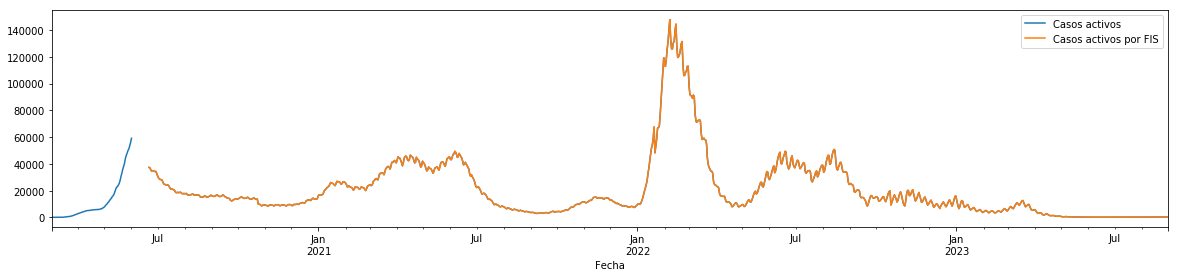

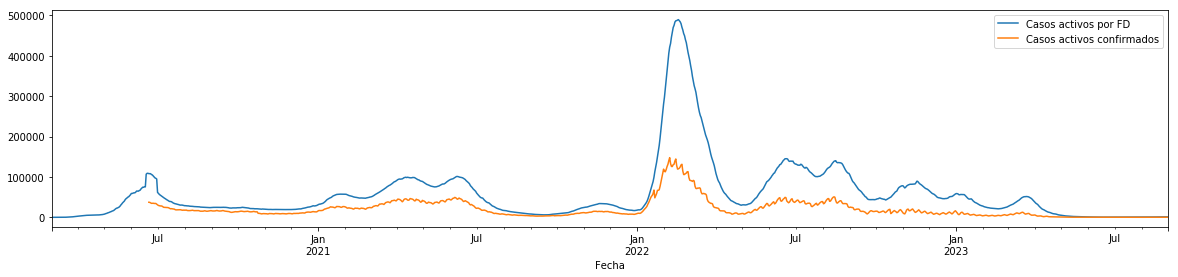

In [4]:
covid_cases_df.plot('Fecha', ['Casos activos', 'Casos activos por FIS'], figsize=(20, 4,))
covid_cases_df.plot('Fecha', ['Casos activos por FD', 'Casos activos confirmados'], figsize=(20, 4,))

En primer lugar, se grafica la evolución de los casos activos a través del tiempo, buscando determinar una tendencia inicial, para esto, se grafican todas as columnas que representan casos activos. Con respecto a estos gráficos, lo primero que se puede señalar es que la columna de casos activos sólo incluye datos de los primeros meses de la pandemia, por lo tanto, corresponde a datos que no serán usados en la posterior predicción, mientras que las series de casos activos confirmados y casos activos por FIS no poseen datos en el inicio de la pandemia. Por otra parte, las series graficadas siguen una tendencia general muy siimlar entre si, estando la principal diferencia en los valores contabilizados, así, todas las series tiene su peak absoluto en la misma fecha, pero los casos activos por FD entregan superiores por más del doble que el resto de las series

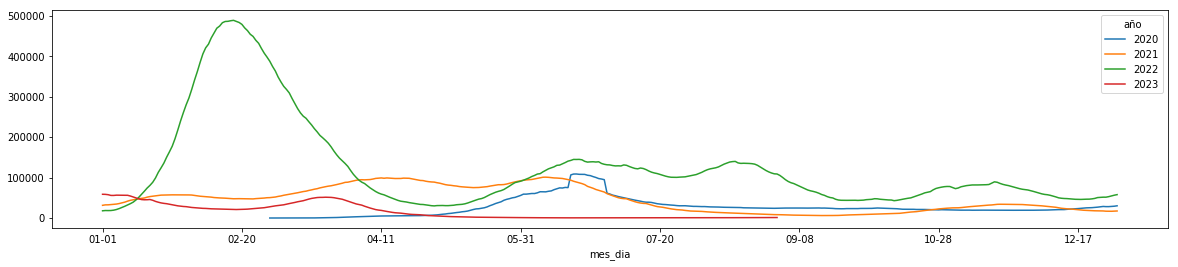

In [5]:
covid_cases_df['año'] = covid_cases_df['Fecha'].dt.year
covid_cases_df['mes_dia'] = covid_cases_df['Fecha'].dt.strftime('%m-%d')

active_cases_unstacked = covid_cases_df.set_index(['año', 'mes_dia'])['Casos activos por FD'].unstack(-2)
active_cases_unstacked.plot(figsize=(20, 4,))

Luego, al graficar la forma en la que ha ido cambiando el total de casos activos a través del año, teniendo una serie por cada uno de los gráficos, se puede notar claramente que no existe estacionalidad a través de los años, esto quiere decir, que cada año hace seguido una tendencia diferente de total de casos activos. Esto se debe a varios factores, entre esos, el cambio de metodología de contabilización de casos a lo largo de la pandemia, la accesibilidad a tests durante la pandemia, así como también a la misma mutación del COVID-19 a través del tiempo, lo que exploca por ejemplo el gran aumento de casos duranye el inicio del 2022, con respecto al resto del periodo observado. Dicho esto, existe una relativa similitud en la tendencia entre todas las series en el periodo comprendido aproximadamente inicios de mayo y mitad de Julio, siendo esto especialmente visible entre las series del 2020 y 2022

Teniendo esto en cuenta, se realiza el mismo análisis para la razón entre la suma de personas recuperadas y fallecidos, y casos nuevos totales, variables que tienen directa relación con el total de casos activos

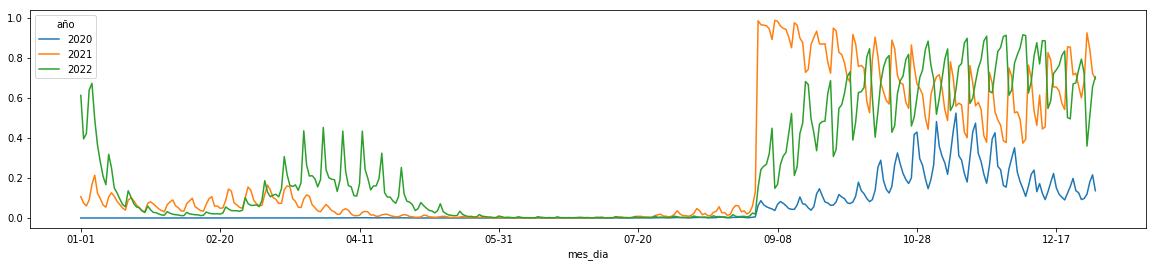

In [6]:
covid_cases_df['Tasa de recuperados y fallecidos FD'] = (
    covid_cases_df['Casos recuperados por FD'] + covid_cases_df['Fallecidos']
) / (
    covid_cases_df['Casos nuevos totales']
).fillna(0).replace([np.inf], 1000000)
active_cases_unstacked = covid_cases_df.set_index(
    ['año', 'mes_dia']
)['Tasa de recuperados y fallecidos FD'].unstack(-2).fillna(0).replace([np.inf], 1000000)
active_cases_unstacked_n = normalize(active_cases_unstacked)
active_cases_unstacked = pd.DataFrame(
    active_cases_unstacked_n, columns=active_cases_unstacked.columns, index=active_cases_unstacked.index
)

active_cases_unstacked.plot(y=[2020, 2021, 2022], figsize=(20, 4,))

Al comparar este gráfico con los obtenidos anteriormente, es posible notar una mayor precencia de estacionalidad, sobre todo comparando los datos de 2021 y 2022. Uno de los factores que podría influir en esto es la estabilidad en procedimineots y esándares de contabiización de casos, así como también facotres culturales relacionados con el hecho de estar varios meses viviendo ya en pandemia. Por otra parte, es importante mencionar que, en este caso, no fueron considerados los datos del año 2023, ya que, comparados con años anteriores, existe una fuerte disminución de casos activos, acompañada por un aumento de personas recuperadas, por lo tanto, no son datos comparables con los años 2020, 2021 y 2022. Esta decisión se encuentra sustentada también en el cambio de regulación y restricciones respecto al COVID indicadas por el ministerio de salud a fines de 2022, y con mayor fuerza en 2023 

**Predicción de máximo anual de casos activos de COVID**

El máximo anual de casos activos de COVID se puede entender como la suma de los máximos de casos activos diarios a nivel anual, por lo tanto, para abordar este problema, se opta por predecir el máximo diario de casos activos, y luego obtener la suma anual. Para esto, teniendo en cuenta que, según el análisis realizado anteriormente, los mayores valores de casos activos, durante todo el periodo, son los de la columna *Casos activos por FD*, se entenderá el máximo de casos activos como el valor presente en esta columna, por lo tanto, este será el valor que se buscará predecir

Teniendo en cuenta que la columna a predecir no tiene un comportamiento marcado de carácter estacional, se opta por utilizar Prophet como modelo base para la predicción de casos activos. Además, teniendo en cuenta que, según lo solicitado, sólo se deben entregar predicciones de casos para años de alerta sanitaria, es decir, el periodo comprendido entre 2020 y 2023, se busca replicar mediante el modelo la serie de tiempo de casos activos a la fecha, por sobre predecir el total de casos activos para un periodo posterior al incluido en los datos entregados

Por otra parte, teniendo en cuenta que el total de casos activos no puede ser negativo, y que no se buscan obtener valores máximos superiores al máximo histórico de casos activos, se modifica el parámetro growth de prophet a *logistic*, y de agregan las columnas *floor*, fijada como 0, y *cap*, fijada como el máximo de casos activos a nivel diario, las que definen respectivamente el mínimo y máximo valor posible que puede predecir el modelo. En esta misma línea, se asegura el correcto ajuste del modelo definiendo un proceso de Grid Search, sobre un diccionario de posibles parámetros. El mejor modelo será seleccionado según el error porcentual absoulto medio (MAPE)

A continuación, se muestra el entrenamiento del modelo, junto con un gráfico donde se compara la serie de tiempo predecida con la real

In [7]:
#definición de variables a usar para entrenamiento de modelo
model_data = covid_cases_df.rename(columns={'Fecha':'ds', 'Casos activos por FD':'y'})[['ds', 'y']]
model_data['cap'] = model_data['y'].max()
model_data['floor'] = 0

In [8]:
#entrenamiento y ajuste del modelo según Grid Search
model, score = train_and_adjust_prophet_model(model_data, PROPHET_PARAMS_GRID)

21:38:26 - cmdstanpy - INFO - Chain [1] start processing
21:38:28 - cmdstanpy - INFO - Chain [1] done processing
21:38:29 - cmdstanpy - INFO - Chain [1] start processing
21:38:32 - cmdstanpy - INFO - Chain [1] done processing
21:38:32 - cmdstanpy - INFO - Chain [1] start processing
21:38:37 - cmdstanpy - INFO - Chain [1] done processing
21:38:37 - cmdstanpy - INFO - Chain [1] start processing
21:38:41 - cmdstanpy - INFO - Chain [1] done processing
21:38:42 - cmdstanpy - INFO - Chain [1] start processing
21:38:47 - cmdstanpy - INFO - Chain [1] done processing
21:38:47 - cmdstanpy - INFO - Chain [1] start processing
21:38:52 - cmdstanpy - INFO - Chain [1] done processing
21:38:52 - cmdstanpy - INFO - Chain [1] start processing
21:38:58 - cmdstanpy - INFO - Chain [1] done processing
21:38:59 - cmdstanpy - INFO - Chain [1] start processing
21:39:06 - cmdstanpy - INFO - Chain [1] done processing
21:39:06 - cmdstanpy - INFO - Chain [1] start processing
21:39:11 - cmdstanpy - INFO - Chain [1]

In [9]:
#predicción
future = model.make_future_dataframe(0)
future['cap'] = model_data['y'].max()
future['floor'] = 0

forecast_df = model.predict(future)

c:\users\samuel\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\users\samuel\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


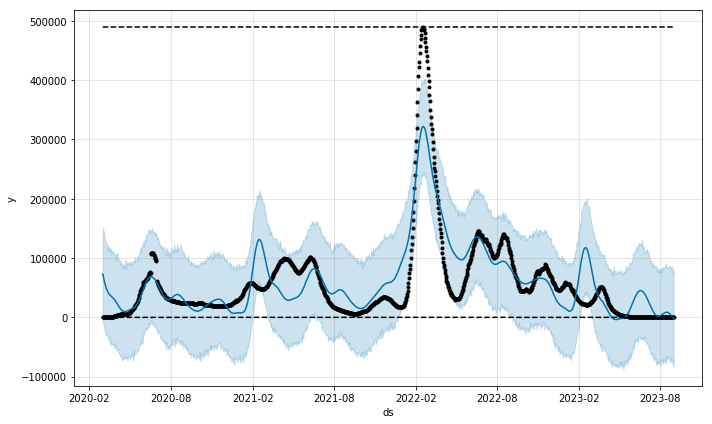

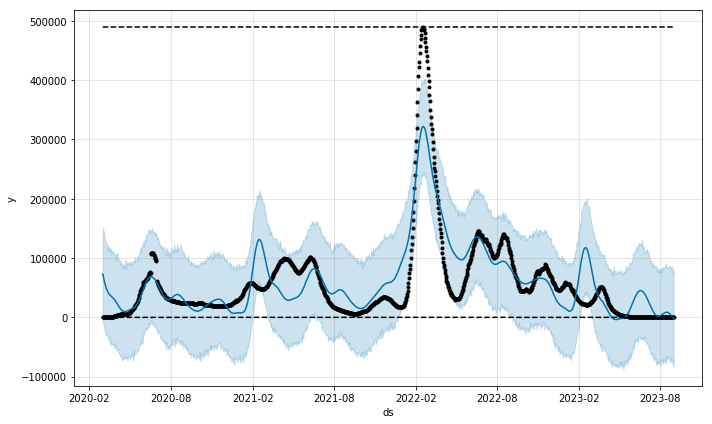

In [10]:
model.plot(forecast_df)

**Muestra de resultados**

Una vez entrenado el modelo, y obtenidas las predicciones, se procede a obtener el máximo de casos activos predicho el cuál es presentado junto a los valores reales de casos máximos

In [11]:
max_active_2020 = round(covid_cases_df[covid_cases_df['Fecha'].dt.year == 2020]['Casos activos por FD'].sum())
max_active_2021 = round(covid_cases_df[covid_cases_df['Fecha'].dt.year == 2021]['Casos activos por FD'].sum())
max_active_2022 = round(covid_cases_df[covid_cases_df['Fecha'].dt.year == 2022]['Casos activos por FD'].sum())
max_active_2023 = round(covid_cases_df[covid_cases_df['Fecha'].dt.year == 2023]['Casos activos por FD'].sum())

f_max_active_2020 = round(forecast_df[forecast_df['ds'].dt.year == 2020]['yhat'].sum())
f_max_active_2021 = round(forecast_df[forecast_df['ds'].dt.year == 2021]['yhat'].sum())
f_max_active_2022 = round(forecast_df[forecast_df['ds'].dt.year == 2022]['yhat'].sum())
f_max_active_2023 = round(forecast_df[forecast_df['ds'].dt.year == 2023]['yhat'].sum())

In [12]:
print(f'El máximo de casos activos de COVID el 2020 fue: {max_active_2020}, se predijeron: {f_max_active_2020}')
print(f'El máximo de casos activos de COVID el 2021 fue: {max_active_2021}, se predijeron: {f_max_active_2021}')
print(f'El máximo de casos activos de COVID el 2022 fue: {max_active_2022}, se predijeron: {f_max_active_2022}')
print(f'El máximo de casos activos de COVID el 2023 fue: {max_active_2023}, se predijeron: {f_max_active_2023}')

El máximo de casos activos de COVID el 2020 fue: 8292746, se predijeron: 8847381
El máximo de casos activos de COVID el 2021 fue: 16847699, se predijeron: 18520009
El máximo de casos activos de COVID el 2022 fue: 44934219, se predijeron: 43371926
El máximo de casos activos de COVID el 2023 fue: 3961515, se predijeron: 6884157


Para evaluar el modelo obtenido, se decide utilizar el error cuadrado medio (RMSE) sobre la suma anual de máximo de casos activos de COVID. El error obtenido en este caso es mostrado a continuación:

In [13]:
mse = mean_squared_error(
    [max_active_2020, max_active_2021, max_active_2022, max_active_2023],
    [f_max_active_2020, f_max_active_2021, f_max_active_2022, f_max_active_2023]
)
print(f'RMSE:{sqrt(abs(mse))}')

RMSE:12809.503717943175
